# Max-Cut Problem
Given an undirected graph $G(V,E)$, partition the vertices into 2 subsets such that the number of edges between the 2 subsets is maximized (max edges "cut")

Solve using QUBO with CPU and QPU

In [2]:
# import necessary packages
import numpy as np
import numpy.random as random

import dimod

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import LazyEmbeddingComposite
from dwave import inspector

import networkx as nx

import time

## Function for solving QUBO

In [3]:
def solve_qubo(Q,
               sampler="CPU", # CPU or QPU
               k=10,
               chain_strength=None):
    """
    Given an upper triangular matrix Q of size NxN, solves the quadratic unconstrained binary
    optimization (QUBO) problem given by
    
        minimize sum(x[i] * Q[i,j] * x[j]
                     for i in range(N),
                     for j in range(i+1, N))
    
    Uses dimod.SimulatedAnnealingSampler, which solves the problem k times through simulated
    annealing (on a regular CPU). This method returns the best solution found.
    """
    assert isinstance(Q, np.ndarray)
    assert sampler in ["CPU", "QPU"]
    n = Q.shape[0]
    nz = len(Q[Q!=0])
    print("Solving QUBO problem (%d vars, %d nz) on %s..." % (n, nz, sampler))
    
    start = time.time()
    if sampler == "CPU":
        sampler = dimod.SimulatedAnnealingSampler()
        response = sampler.sample_qubo(Q, num_reads=k)
    else:
        if chain_strength is None:
            chain_strength = int(10 * np.max(np.abs(Q)))
        sampler = LazyEmbeddingComposite(DWaveSampler(solver="Advantage_system6.1"))
        response = sampler.sample_qubo(Q, num_reads=k, chain_strength=chain_strength)
    elapsed = time.time() - start
    
    print("Solved in %.2f seconds" % elapsed)
    solution = min(response.data(["sample", "energy"]), key=lambda s: s.energy)
    return solution, response

## Generate random graph

73


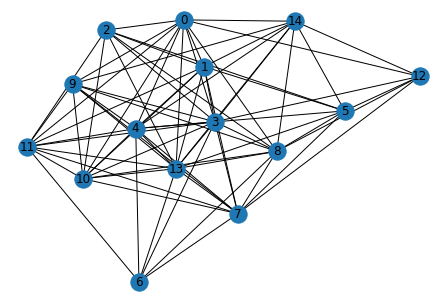

In [23]:
# --- Use graph from Glover's example ---
# # given adjacency matrix make plot of graph

# # adjacency matrix
# G = np.array([[0,1,1,0,0],
#                   [1,0,0,1,0],
#                   [1,0,0,1,1],
#                   [0,1,1,0,1],
#                   [0,0,1,1,0]])

# # make graph
# graph = nx.Graph()
# graph.add_nodes_from([0,np.shape(graph)[0]])

# rows, columns = np.shape(G)
# for i in range(rows):
#     for j in range(columns):
#         if G[i][j] == 1:
#             graph.add_edge(i,j)
            
# nx.draw(graph, with_labels=True)

# number of nodes
n = 15
# edge generation probability
p = 0.65
# seed (optional)
seed = 42
#generate graph
graph = nx.gnp_random_graph(n,p,seed)

# draw graph
nx.draw(graph, with_labels=True)

print(len(graph.edges))

## Generate matrix  for QUBO
Objective function is: min $y=\sum_{(i,j)\in E}(2x_ix_j-x_i-x_j) = x^TQx$

Generate upper triangular matrix $Q$

In [24]:
Q = np.zeros([n,n])
for (i,j) in graph.edges:
    Q[i,j] += 2
    Q[i,i] -= 1
    Q[j,j] -= 1
    
print(Q)

[[-11.   2.   2.   2.   2.   0.   0.   0.   2.   2.   2.   2.   2.   2.
    2.]
 [  0. -10.   2.   2.   2.   2.   0.   2.   0.   0.   2.   2.   0.   2.
    2.]
 [  0.   0.  -8.   2.   0.   2.   0.   0.   2.   0.   2.   2.   0.   2.
    0.]
 [  0.   0.   0. -13.   2.   0.   2.   2.   2.   2.   2.   2.   2.   2.
    2.]
 [  0.   0.   0.   0. -11.   2.   2.   2.   0.   2.   2.   2.   0.   2.
    2.]
 [  0.   0.   0.   0.   0.  -8.   0.   2.   2.   0.   0.   0.   2.   2.
    2.]
 [  0.   0.   0.   0.   0.   0.  -6.   2.   2.   0.   0.   2.   0.   2.
    0.]
 [  0.   0.   0.   0.   0.   0.   0. -11.   2.   2.   2.   2.   2.   2.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. -11.   2.   2.   0.   2.   2.
    2.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.  -9.   2.   2.   0.   2.
    2.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. -10.   2.   0.   2.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. -10.   0.   2.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.   0

## Solve QUBO using CPU

In [25]:
k=10
# solve problem
solution1, response1 = solve_qubo(Q,"CPU",k)

# display result
print(response1)
# for smple, energy, num_occ in response.data(['sample','energy','num_occurrences']):
#     print(num_occ)

Solving QUBO problem (15 vars, 88 nz) on CPU...
Solved in 1.15 seconds
   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 energy num_oc.
0  0  1  0  0  1  0  0  0  1  1  0  1  1  1  0  -46.0       1
1  1  0  1  1  0  1  1  1  0  0  1  0  0  0  1  -46.0       1
2  1  0  1  0  0  1  1  1  0  1  1  0  0  0  1  -46.0       1
3  0  1  1  0  1  0  0  0  1  1  0  0  1  1  0  -46.0       1
4  1  0  0  1  0  1  1  1  0  0  1  0  0  0  1  -46.0       1
5  1  0  0  1  0  1  1  1  0  0  1  0  0  0  1  -46.0       1
6  1  0  0  1  0  1  1  1  0  0  1  0  0  0  1  -46.0       1
7  0  1  0  1  1  0  0  0  1  0  0  1  1  1  0  -46.0       1
8  1  0  1  1  0  1  1  1  0  0  1  0  0  0  1  -46.0       1
9  0  1  1  0  1  0  1  0  1  1  0  0  1  1  0  -46.0       1
['BINARY', 10 rows, 10 samples, 15 variables]


In [26]:
print(solution1)

Sample(sample={0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0}, energy=-46.0)


## Redraw graph with solution

edges cut:  46.0


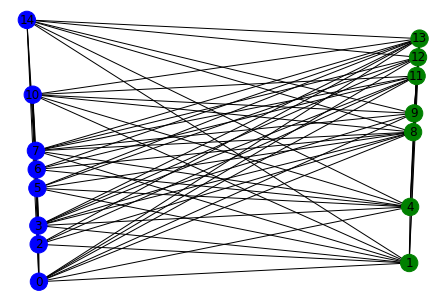

In [27]:
# assign colors
color_map = []
for node in graph:
    if solution1.sample[node] < 0.5:
        color_map.append('blue')
    else: 
        color_map.append('green')
        
# assign positions     
pos = {}
for i in range(n):
    if solution1.sample[i] > 0.5:
        pos[i] = (2*n+0.005*i**2,i)
    else:
        pos[i] = (0-0.005*i**2,i)
nx.draw(graph,pos=pos, node_color=color_map, with_labels=True)

print("edges cut: ", -solution1.energy)

## Solve using QPU

In [28]:
k=3000
# solve problem
solution, response = solve_qubo(Q,"QPU",k)
print(solution)

Solving QUBO problem (15 vars, 88 nz) on QPU...
Solved in 2.28 seconds
Sample(sample={0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 0, 12: 0, 13: 0, 14: 1}, energy=-45.0)


In [29]:
# display result
print(response)

      0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 energy num_oc. chain_b.
0     1  0  0  1  0  1  1  1  0  1  1  0  0  0  1  -45.0       1      0.0
1     1  0  0  1  0  1  0  1  0  0  1  0  0  1  1  -45.0       1      0.0
2     1  0  0  0  0  1  1  1  0  0  1  1  0  1  1  -44.0       1      0.0
3     0  0  1  1  1  0  0  0  1  0  0  1  1  1  0  -44.0       1      0.0
4     0  1  0  1  0  0  0  0  1  1  0  1  1  1  0  -44.0       1      0.0
5     0  0  0  1  1  1  0  0  1  0  1  1  1  1  0  -44.0       1      0.0
6     0  0  1  0  1  0  0  0  1  0  1  1  1  1  1  -44.0       1      0.0
7     0  0  0  1  1  1  0  0  1  0  1  1  0  1  0  -44.0       1      0.0
8     0  0  1  0  1  0  0  1  0  0  0  1  1  1  1  -44.0       1      0.0
9     0  1  0  1  0  1  1  0  0  1  1  1  1  0  0  -44.0       1      0.0
10    0  0  1  0  0  1  1  0  0  1  1  1  1  0  1  -44.0       1      0.0
11    0  0  0  1  0  1  0  1  0  0  1  1  0  1  1  -44.0       1      0.0
12    0  0  0  1  1  1  0  0  1  0  0 

## Redraw graph with solution

edges cut:  45.0


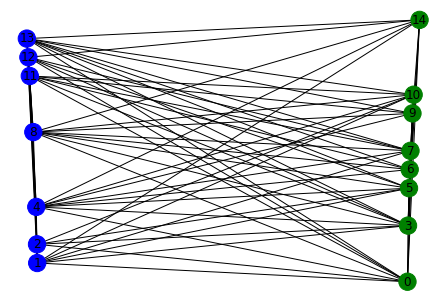

In [30]:
# assign colors
color_map = []
for node in graph:
    if solution.sample[node] < 0.5:
        color_map.append('blue')
    else: 
        color_map.append('green')
        
# assign positions     
pos = {}
for i in range(n):
    if solution.sample[i] > 0.5:
        pos[i] = (2*n+0.005*i**2,i)
    else:
        pos[i] = (0-0.005*i**2,i)
nx.draw(graph, pos=pos, node_color=color_map, with_labels=True)

print("edges cut: ", -solution.energy)

In [11]:
inspector.show(response)

'http://127.0.0.1:18000/?problemId=0afebb84-fe7b-414c-b94c-97ebdd2cca6e'